## Preparation

Make sure that your Colab Notebook has access to a GPU!

In [74]:
# fix locale, to prevent future flaky errors

import locale
locale.getpreferredencoding = lambda: "UTF-8"

# install required libraries via pip

!pip install diffusers
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# import libraries

import gensim.downloader
import os
import torch
import numpy as np

from diffusers import StableDiffusionPipeline
from PIL import Image
from scipy.spatial.distance import cosine
from transformers import BlipProcessor, BlipForConditionalGeneration

In [36]:
# create folders if they don't exist already

folder_names = ['embeddings', 'images', 'models']

# check and create folders if they don't exist
for folder_name in folder_names:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created.")
    else:
        print(f"Folder '{folder_name}' already exists.")

Folder 'embeddings' already exists.
Folder 'images' already exists.
Folder 'models' already exists.


## Stable Diffusion (Text to Image)

In [8]:
pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', torch_dtype=torch.float16)
pipe = pipe.to('cuda')

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/50 [00:00<?, ?it/s]

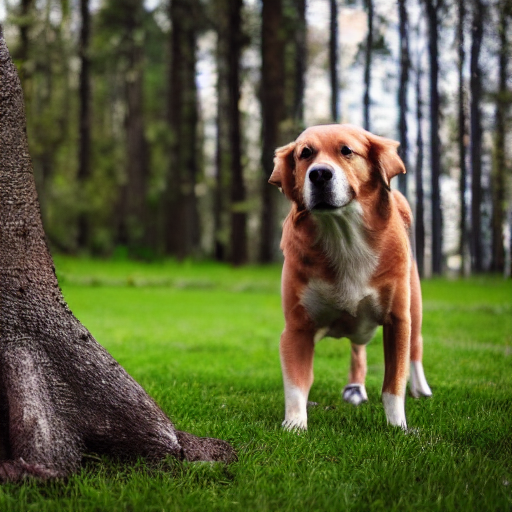

In [9]:
initial_caption = 'a dog and a tree'
image1 = pipe(initial_caption).images[0]

image1.save('images/image1.png')

image1.show()

### BLIP (Image to text)

In [10]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")
 
raw_image = Image.open('images/image1.png').convert('RGB')


In [11]:
inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
image1_caption = processor.decode(out[0], skip_special_tokens=True)
print(image1_caption)

a dog standing next to a tree in the grass


## Comparison

In [12]:
# Download Google News Word Embedding. If it's downloaded already it won't do it again!

embedding_path = 'embeddings/word2vec-google-news-300.bin'
embedding_name = 'word2vec-google-news-300'

if os.path.exists(embedding_path):
    print("Word Embedding has been downloaded already.")
else:
  google_news_embedding = gensim.downloader.load(embedding_name)
  google_news_embedding.save(embedding_path)


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [13]:
google_news_word_embedding = gensim.models.KeyedVectors.load(embedding_path)

def get_mean_vector(sentence, word_embedding):
  tokens = sentence.split()
  embedding = [word_embedding[word] for word in tokens if word in word_embedding]

  if len(embedding) > 0:
    return np.mean(embedding, axis=0)
  else:
    return None

initial_caption_mv = get_mean_vector(initial_caption, google_news_word_embedding)
image1_caption_mv = get_mean_vector(image1_caption, google_news_word_embedding)

## Results


Initial Caption: a dog and a tree

Image 1:


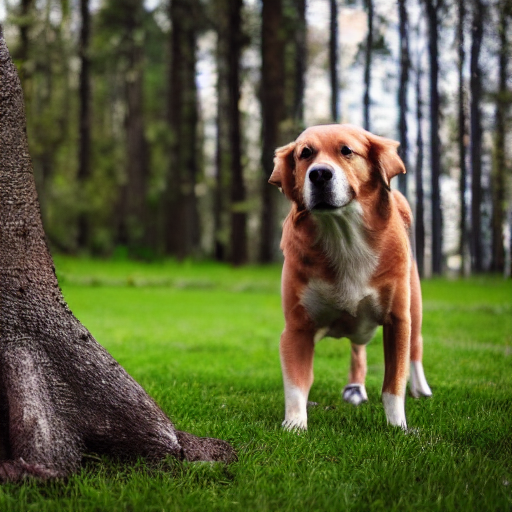


Image 1 Caption: a dog standing next to a tree in the grass


Similarity between the sentences: 0.7778706550598145


In [14]:
def calculate_mv_similarity(sentence_1_mv, sentence_2_mv):
  if sentence_1_mv is not None and sentence_2_mv is not None:
    similarity = 1 - cosine(sentence_1_mv, sentence_2_mv)
    return similarity
  else:
    return None


print(f'\nInitial Caption: {initial_caption}\n')
print(f'Image 1:')
image1.show()
print(f'\nImage 1 Caption: {image1_caption}\n')
similarity = calculate_mv_similarity(initial_caption_mv, image1_caption_mv)
print(f'\nSimilarity between the sentences: {similarity}')

## Discussion and improvements

**Disclaimer:** Since generativ AI is involved your results might change if you rerun the notebook for yourself. However, the general results should stay similar, especially if you use more detailled prompts. The dog and tree example is rather general and unspecific. (For example the color of the dog might change or ihis position).

### Possible Improvements:

1. Improve prompt details
2. Use conditional formatting for BLIP
3. Finetune the Stable Diffusion model
4. Use a different word embedding
5. A combination of the Methods above


##Detailed Prompts

Let's try it. Maybe we can get a better performance if we add more details to our prompt.

But first let's create a function, so we can properly use the things and avoid duplicate code as much as possible.

In [15]:
def run_pipeline(initial_caption, word_embedding):
  # generate image
  image1 = pipe(initial_caption).images[0]
  image1.save('images/image1.png')

  # generate caption from image
  raw_image = Image.open('images/image1.png').convert('RGB')
  inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)
  out = model.generate(**inputs)
  image1_caption = processor.decode(out[0], skip_special_tokens=True)

  # compare captions
  initial_caption_mv = get_mean_vector(initial_caption, word_embedding)
  image1_caption_mv = get_mean_vector(image1_caption, word_embedding)

  # print results
  print(f'\nInitial Caption: {initial_caption}\n')
  print(f'Image 1:')
  image1.show()
  print(f'\nImage 1 Caption: {image1_caption}\n')
  similarity = calculate_mv_similarity(initial_caption_mv, image1_caption_mv)
  print(f'\nSimilarity between the sentences: {similarity}')

  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a golden retriever sits in front of an oak

Image 1:


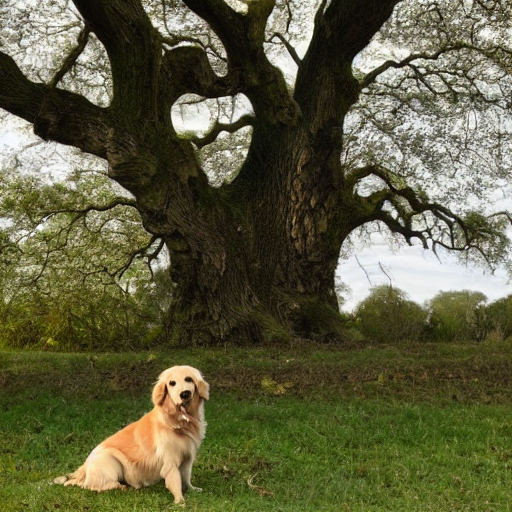


Image 1 Caption: a dog sitting in the grass under a large tree


Similarity between the sentences: 0.617673933506012


In [16]:
run_pipeline('a golden retriever sits in front of an oak', google_news_word_embedding)

It looks like BLIP is not giving out information about the race of the dog, so it's not gonna help us in this case to specify it.

  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a dog laying on the grass in the yard

Image 1:


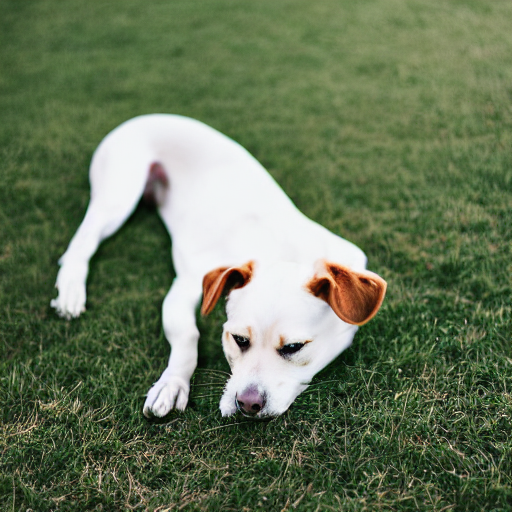


Image 1 Caption: a dog laying on the grass


Similarity between the sentences: 0.9162070155143738


In [17]:
run_pipeline('a dog laying on the grass in the yard', google_news_word_embedding)

This looks better, but maybe we can improve it even more if we add the color to the caption.

  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a black dog laying in the grass

Image 1:


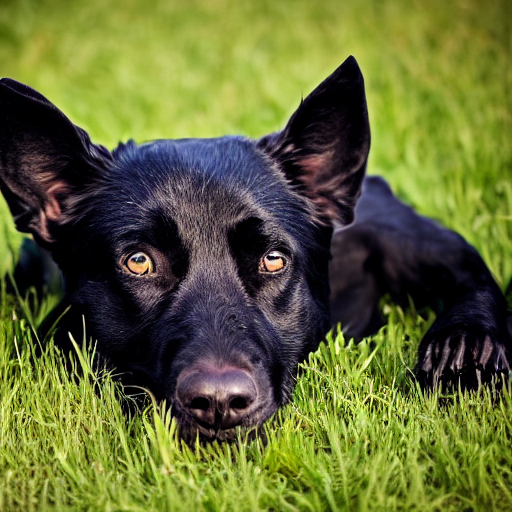


Image 1 Caption: a black dog laying in the grass


Similarity between the sentences: 1


In [18]:
run_pipeline('a black dog laying in the grass', google_news_word_embedding)

Even better with the color, also the gras seems to be a good prompt. But enough of dogs, let's test something completely different.

  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: Mozart playing the drums

Image 1:


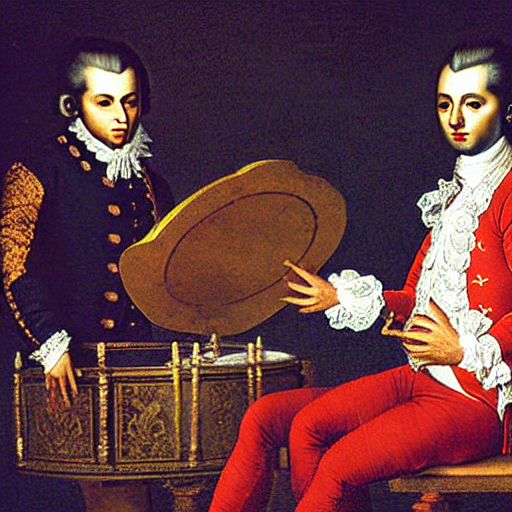


Image 1 Caption: two men in red suits and white shirts, one holding a drum


Similarity between the sentences: 0.34688109159469604


In [19]:
run_pipeline('Mozart playing the drums', google_news_word_embedding)

Names don't seem to be a good addition. Let's try and use the generated caption to see how it performs.

  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a man in a suit playing a drum

Image 1:


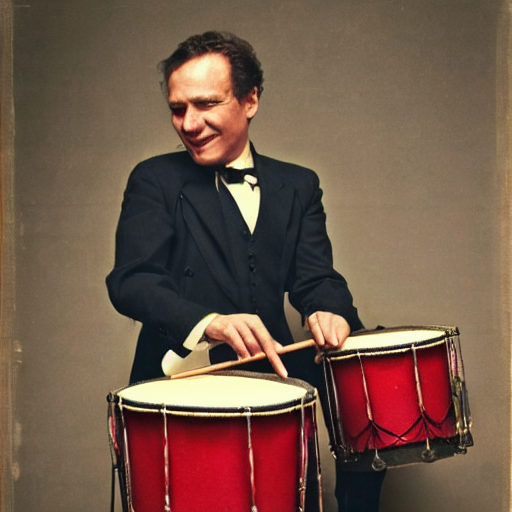


Image 1 Caption: a man in a suit playing drums


Similarity between the sentences: 0.929082989692688


In [20]:
run_pipeline('a man in a suit playing a drum', google_news_word_embedding)

This seems to work great as well, so simple sentences based on the BLIP output seem to perform very well. 
However, this is nothing very new or surprising. But maybe we can finetune the stable diffusion model with some more data and see how the results are.

## Conditional Formatting BLIP

With Conditional Formatting we can add a prefix to the caption that is generated by BLIP, with this we can further control the outputs.

Let's test how the results perform. For this we extend our existing run_pipeline function with a caption_prefix:

In [21]:
def run_pipeline_cf(initial_caption, word_embedding, caption_prefix):
  # generate image
  image1 = pipe(initial_caption).images[0]
  image1.save('images/image1.png')

  # generate caption from image
  raw_image = Image.open('images/image1.png').convert('RGB')
  inputs = processor(raw_image, caption_prefix, return_tensors="pt").to("cuda", torch.float16)
  out = model.generate(**inputs)
  image1_caption = processor.decode(out[0], skip_special_tokens=True)

  # compare captions
  initial_caption_mv = get_mean_vector(initial_caption, word_embedding)
  image1_caption_mv = get_mean_vector(image1_caption, word_embedding)

  # print results
  print(f'\nInitial Caption: {initial_caption}\n')
  print(f'Image 1:')
  image1.show()
  print(f'\nImage 1 Caption: {image1_caption}\n')
  similarity = calculate_mv_similarity(initial_caption_mv, image1_caption_mv)
  print(f'\nSimilarity between the sentences: {similarity}')
  

  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a man in a suit playing a drum

Image 1:


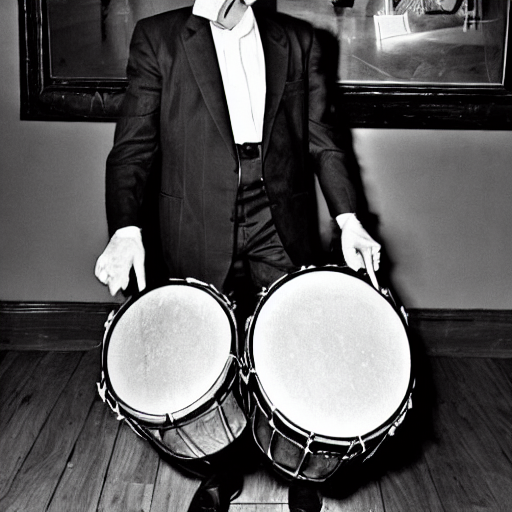


Image 1 Caption: a painting of a man in a suit and tie


Similarity between the sentences: 0.7288691997528076


In [22]:
run_pipeline_cf('a man in a suit playing a drum', google_news_word_embedding, 'a painting of')

This looks nice, but let's further similarize the captions by also adding the prefix to the initial caption:

  0%|          | 0/50 [00:00<?, ?it/s]


Initial Caption: a painting of a man in a suit playing a drum

Image 1:


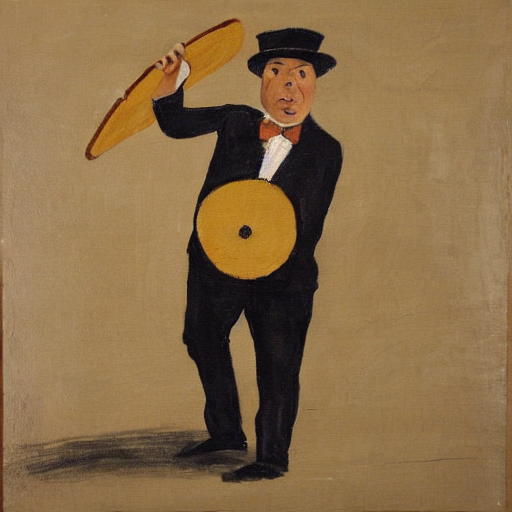


Image 1 Caption: a painting of a man in a tuxed suit


Similarity between the sentences: 0.8595989942550659


In [23]:
run_pipeline_cf('a painting of a man in a suit playing a drum', google_news_word_embedding, 'a painting of')

The similarity improves again, which is good to see. So the conditional Formatting of BLIP seems to improve the results

## Scaling up the process

Now we tested a lot of single images. The results are generally consistent. However, since we're working with generative AI, the results differ from time to time. 

So to furthe prove the progress we're making let's pump up the numbers. Instead of running the pipeline once with the prompt, we run the pipeline multiple times and check the mean similarity between the initial and the generated caption.

Let's compare the two methods with 50 runs each. More would be nice of course, 
to reduce the variance, but each image takes 10 seconds to generate. So it takes a lot more time if we increase it.

First the method without the conditional formatting:

In [24]:
# rewrite the function to prevent output spam

def run_pipeline_no_print(initial_caption, word_embedding):
  # generate image
  image1 = pipe(initial_caption).images[0]
  image1.save('images/image1.png')

  # generate caption from image
  raw_image = Image.open('images/image1.png').convert('RGB')
  inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)
  out = model.generate(**inputs)
  image1_caption = processor.decode(out[0], skip_special_tokens=True)

  # compare captions
  initial_caption_mv = get_mean_vector(initial_caption, word_embedding)
  image1_caption_mv = get_mean_vector(image1_caption, word_embedding)

  return calculate_mv_similarity(initial_caption_mv, image1_caption_mv)

In [25]:
num_runs = 50

results = []
for i in range(num_runs):
    result = run_pipeline_no_print('a man in a suit playing a drum', google_news_word_embedding)
    results.append(result)

mean_result = sum(results) / len(results)

print(mean_result)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0.8399486011266708


Now let's run the same with conditional formatting:

In [26]:
# rewrite the function to prevent output spam

def run_pipeline_cf_no_print(initial_caption, word_embedding, caption_prefix):
  # generate image
  image1 = pipe(initial_caption).images[0]
  image1.save('images/image1.png')

  # generate caption from image
  raw_image = Image.open('images/image1.png').convert('RGB')
  inputs = processor(raw_image, caption_prefix, return_tensors="pt").to("cuda", torch.float16)
  out = model.generate(**inputs)
  image1_caption = processor.decode(out[0], skip_special_tokens=True)

  # compare captions
  initial_caption_mv = get_mean_vector(initial_caption, word_embedding)
  image1_caption_mv = get_mean_vector(image1_caption, word_embedding)

  return calculate_mv_similarity(initial_caption_mv, image1_caption_mv)

In [27]:
num_runs = 50

results = []
for i in range(num_runs):
    result = run_pipeline_cf_no_print('a painting of a man in a suit playing a drum', google_news_word_embedding, 'a painting of')
    results.append(result)

mean_result = sum(results) / len(results)

print(mean_result)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0.8127311098575593


If we compare these numbers now, we see that it doesn't seem to make a big difference, it performs slighty worse even. So we need to find another way to improve the similarity.

Let's try finetuning. But since this notebook already takes quite a long time to complete, let's start in a new notebook. Please open 02_finetuning.ipynb from the repository.